In [1]:
!pip install git+https://github.com/ficstamas/FateML.git graphviz imodels
!pip install --upgrade scikit-learn~=1.2.1

  Cloning https://github.com/ficstamas/FateML.git to c:\users\ftkni\appdata\local\temp\pip-req-build-k_jeemhu
  Resolved https://github.com/ficstamas/FateML.git to commit 26941e5ec188e1c71c0c8e4b0c908b4393099979
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/ficstamas/FateML.git 'C:\Users\ftkni\AppData\Local\Temp\pip-req-build-k_jeemhu'


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# %matplotlib widget  # for jupyter-lab

# Datasets

In this notebook we are going use 2 datasets:
- [Iris dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#iris-plants-dataset) (Classification) 
  - Features: petal length (cm), petal width (cm), sepal length (cm), sepal width (cm)
  - Target: setosa (0), versicolor (1), virginica (2)
- [Diabetes dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) (Regression)
  - Features: age, sex, bmi, bp, s1 (total serum cholesterol), s2 (low-density lipoproteins), s3 (high-density lipoproteins \[HDL\]), s4 (total cholesterol / HDL), s5 (possibly log of serum triglycerides level), s6 (blood sugar level)
  - Target:  quantitative measure of disease progression one year after baseline

In [4]:
from fateml.data import load_dataset

iris = load_dataset("iris", standardize=False, statsmodels_format=False)
diabetes = load_dataset("diabetes", standardize=False, statsmodels_format=False)

In [5]:
iris.train_x

,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm)
105,6.6,2.1,7.6,3.0
85,4.5,1.6,6.0,3.4
15,1.5,0.4,5.7,4.4
70,4.8,1.8,5.9,3.2
34,1.5,0.2,4.9,3.1
...,...,...,...,...
4,1.4,0.2,5.0,3.6
113,5.0,2.0,5.7,2.5
67,4.1,1.0,5.8,2.7
98,3.0,1.1,5.1,2.5


In [6]:
diabetes.train_x

,age,bmi,bp,s1,s2,s3,s4,s5,s6,sex
251,-0.052738,0.098342,0.087287,0.060349,0.048790,-0.058127,0.108111,0.084492,0.040343,0.050680
385,0.023546,-0.019140,0.049415,-0.063487,-0.061125,0.004460,-0.039493,-0.025953,-0.013504,0.050680
162,-0.052738,0.030440,-0.074527,-0.023584,-0.011335,-0.002903,-0.002592,-0.030748,-0.001078,-0.044642
231,0.009016,-0.030996,0.021872,0.008063,0.008707,0.004460,-0.002592,0.009434,0.011349,-0.044642
345,0.081666,-0.002973,-0.033213,0.042462,0.057871,-0.010266,0.034309,-0.000612,-0.001078,0.050680
...,...,...,...,...,...,...,...,...,...,...
404,-0.016412,0.054152,0.070072,-0.033216,-0.027931,0.008142,-0.039493,-0.027129,-0.009362,-0.044642
312,-0.074533,-0.023451,-0.005670,-0.020832,-0.014153,0.015505,-0.039493,-0.038460,-0.030072,-0.044642
433,-0.027310,-0.060097,-0.029770,0.046589,0.019980,0.122273,-0.039493,-0.051404,-0.009362,-0.044642
254,0.030811,0.056307,0.076958,0.049341,-0.012274,-0.036038,0.071210,0.120051,0.090049,0.050680


# Decision Trees

Linear and Logistic regression models are not suitable for scenarios when the features are interacting with eachother and/or a non-linear relationship is present between the target variable amd the features. In such case we can rely on decision trees. A decision tree is a flowchart-like structure in which an internal node represents a feature (or attribute), the branch represents a decision rule, and each leaf node represents the outcome. 

A dicision tree can handle non-linearity, categorical variables, missing data (not all of them, see CART below), and highly interpretable. Additionally, they don't require the data to be normalised or scaled. However decision trees have other issues. They are more prone to overfit the data (if the tree is too deep and complex) and less accurate overall.

<img src="https://github.com/ficstamas/FateML/raw/master/notebooks/images/tree-artificial-1.png" width="500">

## CART - Classification And Regression Trees

A popular decision tree algorithm. It can perform regression and classification tasks as well. The CART algorithm uses a top-down, greedy approach called recursive binary splitting to build the tree. It starts at the root node and selects the attribute that best splits the data into subsets with the most homogeneous class labels (in classification) or output values (in regression). The process is then repeated for each subset recursively, until a stopping criterion is met (e.g., maximum tree depth, minimum number of samples in a leaf node...). CART can only work on clean data, so we have to handle missing values beforehand.

- For classification problems, the Gini impurity is used as the criterion. Gini impurity measures the probability of a random sample being misclassified if it is randomly labeled according to the class distribution in the subset. The split that results in the lowest Gini impurity is chosen as the best split.

- For regression problems, the criterion used is the reduction in variance. The split that results in the largest reduction in variance is chosen as the best split.

In both cases, the algorithm will try all possible splits for all features and it will select the best split using the specified criterion. Once a split is chosen, the algorithm will recursively repeat the process for each subset of the data, until a stopping criterion is met.

It can be formulated as:
$$\hat{y}=\hat{f}(x)=\sum_{m=1}^Mc_mI_{\{x\in R_m\}},$$
where $I_{\{x\in R_m\}}$ is an indicator function which yields 1 if $x\in R_m$ and 0 otherwise. in other words if $x$ is part of node $m$ then it returns 1. Furthermore, $M$ denotes the number of all subsets and an instance ($x$) can only be in exactly one subset.


### Regression

In [7]:
from sklearn.tree import DecisionTreeRegressor

regression_tree = DecisionTreeRegressor(random_state=0, max_depth=3)
regression_tree.fit(diabetes.train_x, diabetes.train_y)

DecisionTreeRegressor(max_depth=3, random_state=0)

In [8]:
from sklearn.metrics import r2_score

r2_score(diabetes.test_y, regression_tree.predict(diabetes.test_x))

0.06595503286274407

#### Visualization

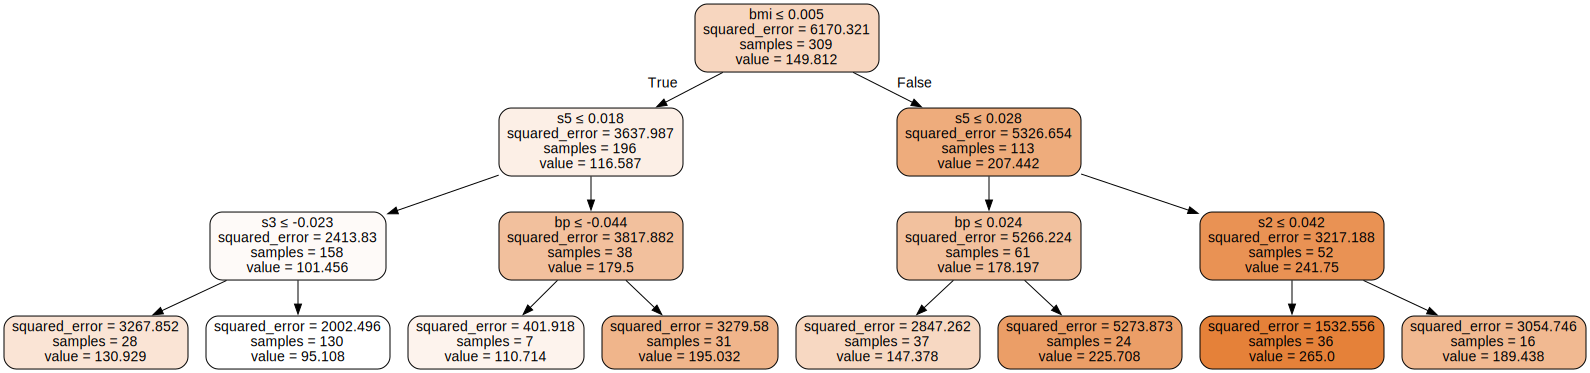

In [9]:
import graphviz
import sklearn.tree as tree

dot_data = tree.export_graphviz(regression_tree, out_file=None, feature_names=diabetes.train_x.columns, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

#### Importance

In [10]:
regression_tree.feature_importances_

array([0.        , 0.53095453, 0.11658503, 0.        , 0.05675555,
       0.02652732, 0.        , 0.26917758, 0.        , 0.        ])

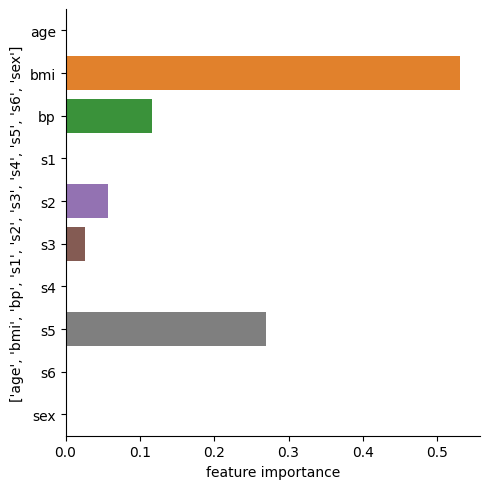

In [11]:
feature_importances = pd.DataFrame(data=regression_tree.feature_importances_, columns=["feature importance"], index=diabetes.train_x.columns)

sns.catplot(kind="bar", data=feature_importances, y=diabetes.train_x.columns.to_list(), x="feature importance", orient="h")

### Classification

In [12]:
from sklearn.tree import DecisionTreeClassifier

classification_tree = DecisionTreeClassifier(random_state=0, max_depth=3)
classification_tree.fit(iris.train_x, iris.train_y)

DecisionTreeClassifier(max_depth=3, random_state=0)

In [13]:
from sklearn.metrics import accuracy_score

accuracy_score(iris.test_y, classification_tree.predict(iris.test_x))

1.0

#### Visualization

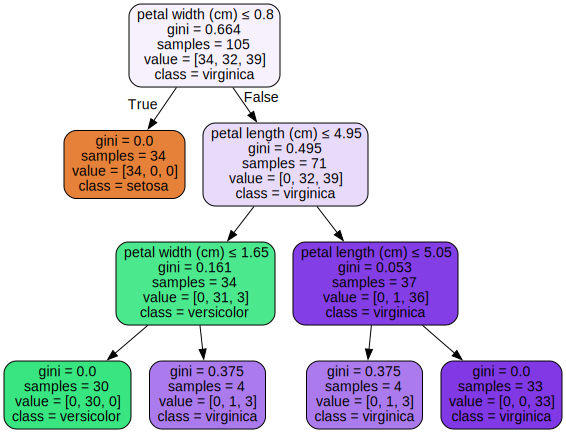

In [14]:
import graphviz
import sklearn.tree as tree

dot_data = tree.export_graphviz(classification_tree, out_file=None, feature_names=iris.train_x.columns, class_names=iris.features["target_names"], filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)  
graph 

#### Feature Importance

**Gini-Impurity:** 

$$
G(D) = 1 - \sum_{i=0}^{k}p_i^2,
$$
where dataset $D$ that contains samples from $k$ classes. The probability of samples belonging to class $i$ at a given node can be denoted as $p_i$.

**Remark:** Why do we used squered proabilities in the Gini Impurity?

The above equatation can be also expressed as:
$$\sum_{i=0}^{k}p_i(1 - p_i),$$
which expresses the probability of incorrectly classifying a randomly chosen element, which can be reformulated as:
$$\sum_{i=0}^{k}p_i(1 - p_i)=\sum_{i=0}^{k}p_i - p_i^2=\left(\sum_{i=0}^{k}p_i\right)-\left(\sum_{i=0}^{k}p_i^2\right)=1-\sum_{i=0}^{k}p_i^2$$

''

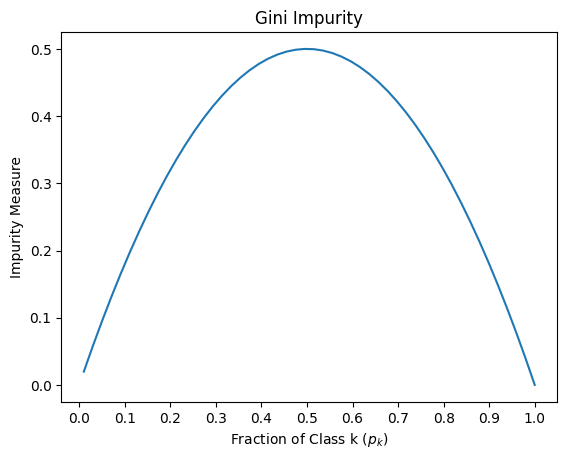

In [2]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0.01,1)
y = 1 - (x*x) - (1-x)*(1-x) 

plt.plot(x,y)
plt.title('Gini Impurity')
plt.xlabel("Fraction of Class k ($p_k$)")
plt.ylabel("Impurity Measure")
plt.xticks(np.arange(0,1.1,0.1))
""

In [15]:
classification_tree.feature_importances_

array([0.42222226, 0.57777774, 0.        , 0.        ])

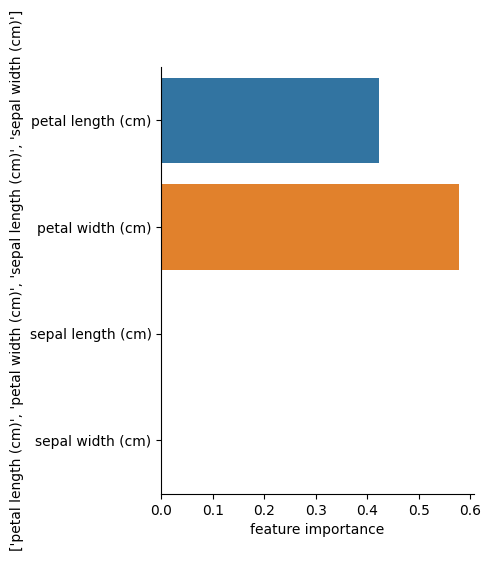

In [16]:
feature_importances = pd.DataFrame(data=classification_tree.feature_importances_, columns=["feature importance"], index=iris.train_x.columns)

sns.catplot(kind="bar", data=feature_importances, y=iris.train_x.columns.to_list(), x="feature importance", orient="h")

# Decision Rules

## OneR

One Rule (OneR) is a simple but surprisingly efficient classification algorithm. Although, it is usually used as a baseline and not as a applicable model. It works by iterating over each feature and creating a rule that uses the feature to predict the class label. The algorithm then selects the feature that results in the highest accuracy.

Outline of the algorithm is as follows:

0. Preprocessing: Discretize all continuous feature
1. Training: Iterate over each feature (columns):
   1. For each feature value, count the number times a label occures with that value.
   2. Regard the class label with the highest frequency (count) as the majority class for each feature value.
   3. Record the error for each feature. ($\frac{miss\_classified}{total}$)
3. Evaluation: Select the feature with the least error and use the corresponting rule to classify the examples

In [17]:
# X_train, y_train
from pandas.api.types import is_float_dtype

class OneR:
    def __init__(self):
        self.meta_ = {"feature": [], "error": [], "most frequent": [], "rules": []}
        self.best_feature_ = -1
        self.best_rules_ = []
        self.most_frequent_ = -1

    def fit(self, X: pd.DataFrame, y: pd.DataFrame):
        for feature in X.columns:
            if is_float_dtype(X[feature]):
                # calculate quantiles
                discr = np.quantile(X[feature], [0.8, 0.6, 0.4, 0.2][::-1])
                discr = np.concatenate([[-np.inf], discr, [np.inf]])  # include infinity to the ranges
                categories = []
                # frequency table
                table = np.zeros([len(discr), len(y.unique())])
                # calculate label frequencies for each feature value
                for i in range(len(discr)-1):
                    lower = discr[i]
                    upper = discr[i+1]
                    categories.append([discr[i], discr[i+1]])

                    freq = y[(lower < X[feature]) & (X[feature] <= upper)].value_counts()
                    for j in freq.index:
                        table[i, j] = freq[j]

                table = table[:-1, :]  # remove padding
                # calculate meta information
                total = np.sum(table)
                self.meta_["most frequent"].append(np.argmax(table, axis=1))
                self.meta_["rules"].append(categories)

                # we are going to set the majority labels for each rule to 0
                # so we can calculate the error for each decision
                # num_miss_classified/total
                table[np.arange(len(table)), np.argmax(table, axis=1)] = 0
                error = np.sum(table)/total
                self.meta_["feature"].append(feature)
                self.meta_["error"].append(error)
                print(feature, error)
        min_idx = np.argmin(self.meta_["error"])
        self.best_feature_ = self.meta_["feature"][min_idx]
        self.best_rules_ = self.meta_["rules"][min_idx]
        self.most_frequent_ = self.meta_["most frequent"][min_idx]

    def predict(self, X):
        selected = X[self.best_feature_]
        predictions = np.zeros([len(X),])
        predictions[:] = -1
        for i, idx in enumerate(selected.index):
            value = selected[idx]
            for j, rule in enumerate(self.best_rules_):
                if rule[0] < value <= rule[1]:
                    predictions[i] = self.most_frequent_[j]
                    break
        return predictions

    def score(self, X, y):
        preds = self.predict(X)
        return len(np.where(y == preds)[0])/len(y)

In [18]:
oner = OneR()

oner.fit(iris.train_x, iris.train_y['target'])

petal length (cm) 0.14285714285714285
petal width (cm) 0.12380952380952381
sepal length (cm) 0.29523809523809524
sepal width (cm) 0.42857142857142855


In [19]:
oner.score(iris.test_x, iris.test_y['target'])

0.9

In [20]:
oner.best_feature_

'petal width (cm)'

In [21]:
oner.best_rules_

[[-inf, 0.2],
 [0.2, 1.1600000000000001],
 [1.1600000000000001, 1.5],
 [1.5, 2.0],
 [2.0, inf]]

In [22]:
import pprint

pprint.pprint(oner.meta_)

{'error': [0.14285714285714285,
           0.12380952380952381,
           0.29523809523809524,
           0.42857142857142855],
 'feature': ['petal length (cm)',
             'petal width (cm)',
             'sepal length (cm)',
             'sepal width (cm)'],
 'most frequent': [array([0, 0, 1, 2, 2], dtype=int64),
                   array([0, 0, 1, 2, 2], dtype=int64),
                   array([0, 1, 1, 2, 2], dtype=int64),
                   array([1, 2, 2, 0, 0], dtype=int64)],
 'rules': [[[-inf, 1.5],
            [1.5, 3.9],
            [3.9, 4.74],
            [4.74, 5.420000000000001],
            [5.420000000000001, inf]],
           [[-inf, 0.2],
            [0.2, 1.1600000000000001],
            [1.1600000000000001, 1.5],
            [1.5, 2.0],
            [2.0, inf]],
           [[-inf, 5.1], [5.1, 5.6], [5.6, 6.14], [6.14, 6.62], [6.62, inf]],
           [[-inf, 2.7], [2.7, 3.0], [3.0, 3.1], [3.1, 3.4], [3.4, inf]]]}


## Sequential Covering

Sequential Covering is an iterative rule-learning algorithm which eliminates a certain part of the dataset with each step and replaces it with a rule. The algorithm is as follows for binary classification:

1. Initiate an empty list of rules ($rlist$)
2. Learn a rule ($r$)
3. As long as the quality of the selected rules is under a predefined threshold or the non-covered datapoints are not homogeneous:
   1. Append $r$ to $rlist$
   2. Cover (/remove) datapoints which are covered by $r$
   3. Learn a new rule $r$ from the non-covered datapoints
   
How can we learn a new rule $r$? There are several methods but right now we are going to rely on decision trees:
- Learn a decision tree (e.g. CART)
- Starting from the root, in a recursive manner, select the child with better purity until a leaf node is reached
- The path defines the rule and the leaf node defines the associated label

<img src="https://github.com/ficstamas/FateML/raw/master/notebooks/images/sequential_covering.png" width=500>

In [23]:
# X_train, y_train
from sklearn.tree import DecisionTreeClassifier
from pprint import pprint

class SequentialCavering:
    def __init__(self):
        self.rules_ = {}
        self.feature_names_in_ = []
        self.learner_ = DecisionTreeClassifier(random_state=0)
        self.outlier_ = -1

    def _path(self, tree):
        children_left = tree.children_left
        children_right = tree.children_right
        feature = tree.feature
        threshold = tree.threshold
        impurity = tree.impurity

        rule = {}
        decision = None

        stack = [(0, 0)]
        while len(stack) > 0:
            node_id, depth = stack.pop()
            cl = children_left[node_id]
            cr = children_right[node_id]

            is_split_node = cl != cr
            if is_split_node:
                if impurity[cl] <= impurity[cr]:
                    rule[len(rule)] = {"leq": True,
                                       "feature": self.feature_names_in_[feature[node_id]],
                                       "threshold": threshold[node_id]}
                    stack.append((cl, depth+1))
                else:
                    rule[len(rule)] = {"leq": False,
                                       "feature": self.feature_names_in_[feature[node_id]],
                                       "threshold": threshold[node_id]}
                    stack.append((cr, depth+1))
            decision = np.argmax(tree.value[node_id])
        return rule, decision
            

    def _remove_covering(self, X, y):
        _X = X.copy()
        all_cond = []
        for _, rule_dict in self.rules_.items():
            rule_cond = []
            rule = rule_dict["rule"]
            for _, condition in rule.items():
                feature = condition["feature"]
                th = condition["threshold"]
                col = _X[feature]
                if condition["leq"]:
                    rule_cond.append(col <= th)
                else:
                    rule_cond.append(col > th)

            conditioned = rule_cond[0]
            for cond in rule_cond:
                conditioned = conditioned & cond
            all_cond.append(conditioned)

        conditioned = all_cond[0]
        for cond in all_cond:
            conditioned = conditioned | cond

        return _X.loc[~conditioned], y.loc[~conditioned]


    def fit(self, X, y, threshold=0.05):
        X = X.copy()
        y = y.copy()

        self.learner_ = self.learner_.fit(X, y)
        self.feature_names_in_ = self.learner_.feature_names_in_

        rule, label = self._path(self.learner_.tree_)
        quality = 2
        while quality > threshold:
            self.rules_[len(self.rules_)] = {"rule": rule, "label": label}
            if quality == 1.0:
                break
            X, y = self._remove_covering(X, y)

            self.learner_ = self.learner_.fit(X, y)
            rule, label = self._path(self.learner_.tree_)
            total = len(y)
            positive = len(np.where(y.values == 1)[0])
            quality = positive/total
        self.outlier_ = y.value_counts().idxmax()


    def predict(self, X):
        _X = X.copy()
        y_pred = np.zeros([len(X), ])
        for _, rule_dict in self.rules_.items():
            rule_cond = []
            rule = rule_dict["rule"]
            if len(rule) == 0:
                continue
            for _, condition in rule.items():
                feature = condition["feature"]
                th = condition["threshold"]
                col = _X[feature]
                if condition["leq"]:
                    rule_cond.append(col <= th)
                else:
                    rule_cond.append(col > th)

            conditioned = rule_cond[0]
            for cond in rule_cond:
                conditioned = conditioned & cond
            y_pred[conditioned.values] = rule_dict["label"]
        y_pred[y_pred == -1] = self.outlier_
        return y_pred
    

    def score(self, X, y):
        preds = self.predict(X)
        return len(np.where(y == preds)[0])/len(y)

    
    def print_rules(self):
        for _, rule in self.rules_.items():
            rule_str = []
            if len(rule['rule']) > 0:
                for _, cond in rule['rule'].items():
                    rule_str.append(f"{cond['feature']} {'<=' if cond['leq'] else '>'} {cond['threshold']:.2f}")
                rule_str = " AND ".join(rule_str)
            else:
                rule_str = "default"
            print(f"IF {rule_str} THEN {rule['label']}")

In [24]:
selected_class = 2
train_y_modified = (iris.train_y['target'] == selected_class).astype(int)
test_y_modified = (iris.test_y['target'] == selected_class).astype(int)

sq = SequentialCavering()
sq.fit(iris.train_x, train_y_modified)

print(sq.score(iris.test_x, test_y_modified))
sq.print_rules()

0.36666666666666664
IF petal length (cm) <= 4.85 AND petal width (cm) <= 1.65 THEN 0
IF petal length (cm) > 5.05 THEN 1
IF sepal width (cm) > 3.05 THEN 0
IF sepal length (cm) > 6.50 THEN 0
IF petal width (cm) > 1.60 THEN 1
IF sepal length (cm) <= 6.15 THEN 1


## Bayesian Rule Lists

Bayesian Rule Lists (BRL) is a machine learning algorithm that is used for binary classification problems. The algorithm starts with an empty rule list and iteratively adds new rules to the list based on the Bayesian network representation.

The algorithm (BRL) has __three main components__:

1. A prior probability distribution over the space of possible rule lists.
2. A likelihood function that computes the probability of observing the data given a particular rule list.
3. A posterior probability distribution over the space of possible rule lists, given the observed data.

By default, it is going to compute the initial list of rules in a greedy manner. We can boost the performance of the BRL algorithm by providing a prior rule set so it can focus on a smaller number of rules. We can determine such initial sets with frequent item mining algorithms, such as Apriori, Park-Chen-Yu and FP-Growth algotihms.

__Apriori algorithm:__ The basic idea behind the Apriori algorithm is that if an itemset is frequent, then all of its subsets must also be frequent. This property is known as the "Apriori property". The algorithm starts with the sets of individual items (1-itemsets) and iteratively generates larger itemsets by combining the frequent itemsets found in the previous step.

0. Init
   - Predefine a support threshold ($t$)
   - $\mathcal{U}\ $ set of possible items, 
   - $\mathcal{T}$ transactional database,
   - $C_1=\mathcal{U}$ initial candidate set
   - Support: $s(x)=\frac{|x \in \mathcal{T}|}{|\mathcal{T}|}$
   - Define a set which contains only the frequent items: $F_1=\{x\mid x\in C_1, s(x)\geq t\}$ (has a higher support then the predefined threshold)
1. for ($k$ = 2; $k$ < $|U|$ && $F_{k−1}$ $\neq$ $∅$; $k$++) do
   1. Combine frequent items ($F_{k-1}$) to obtain $C_k$
   2.  Find a set of frequent items: $F_k=\{x\mid x\in C_k, s(x)\geq t\}$
2. return $\hat{F}=⋃_{i=1}^kF_i$

BRL also has some limitations. It is computationally expensive, especially when the dataset is large and can only work a discretized features. It also requires a good understanding of the prior probability distribution, which can be difficult to specify in practice.


In [25]:
from imodels import BayesianRuleListClassifier
from imodels.discretization import ExtraBasicDiscretizer

# the model only operates on binary classification task
selected_class = 1
target_name = iris.features['target_names'][selected_class]
train_y_modified = (iris.train_y['target'] == selected_class).astype(int)
test_y_modified = (iris.test_y['target'] == selected_class).astype(int)

# discretize dataset and fix the jank
disc = ExtraBasicDiscretizer(iris.train_x.columns, n_bins=3, strategy='uniform')
X_train_brl_df = disc.fit_transform(iris.train_x)
X_train_brl_df = X_train_brl_df.loc[:len(iris.train_x)-1]
X_train_brl_df.index = iris.train_x.index
X_train_brl_df

X_test_brl_df = disc.transform(iris.test_x)
X_test_brl_df = X_test_brl_df.loc[:len(iris.test_x)-1]
X_test_brl_df.index = iris.test_x.index
X_test_brl_df

# fir the model
bayesian_rule = BayesianRuleListClassifier(max_iter=3000, class1label=target_name, verbose=False, random_state=42)
bayesian_rule.fit(X_train_brl_df, train_y_modified, feature_names=X_train_brl_df.columns.tolist())

E:\Programs\Anaconda3\envs\FateML\lib\site-packages\sklearn\preprocessing\_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
E:\Programs\Anaconda3\envs\FateML\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Trained RuleListClassifier for detecting versicolor
====================================================
IF petal length (cm)_4.966666666666667_to_6.9 > 0.5 THEN probability of versicolor: 5.1% (0.6%-13.8%)
ELSE IF petal width (cm)_0.1_to_0.8999999999999999 > 0.5 THEN probability of versicolor: 2.8% (0.1%-10.0%)
ELSE IF petal width (cm)_0.8999999999999999_to_1.7 > 0.5 THEN probability of versicolor: 96.9% (88.8%-99.9%)
ELSE probability of versicolor: 33.3% (5.3%-71.6%)
===================================================

In [26]:
def viz_classification_preds(probs, y_test):
    '''look at prediction breakdown
    '''
    from sklearn import metrics
    fig, axs = plt.subplots(1, 2)
    axs[0].hist(probs[:, 1][y_test==0], label='Class 0')
    axs[0].hist(probs[:, 1][y_test==1], label='Class 1', alpha=0.8)
    axs[0].set_ylabel('Count')
    axs[0].set_xlabel('Predicted probability of class 1')
    axs[0].legend()
    
    preds = np.argmax(probs, axis=1)
    axs[1].set_title('ROC curve')
    fpr, tpr, thresholds = metrics.roc_curve(y_test, preds)
    axs[1].plot([0, 1], [0, 1],'r--')
    axs[1].set_xlabel('False positive rate')
    axs[1].set_ylabel('True positive rate')
    axs[1].plot(fpr, tpr)
    fig.tight_layout()

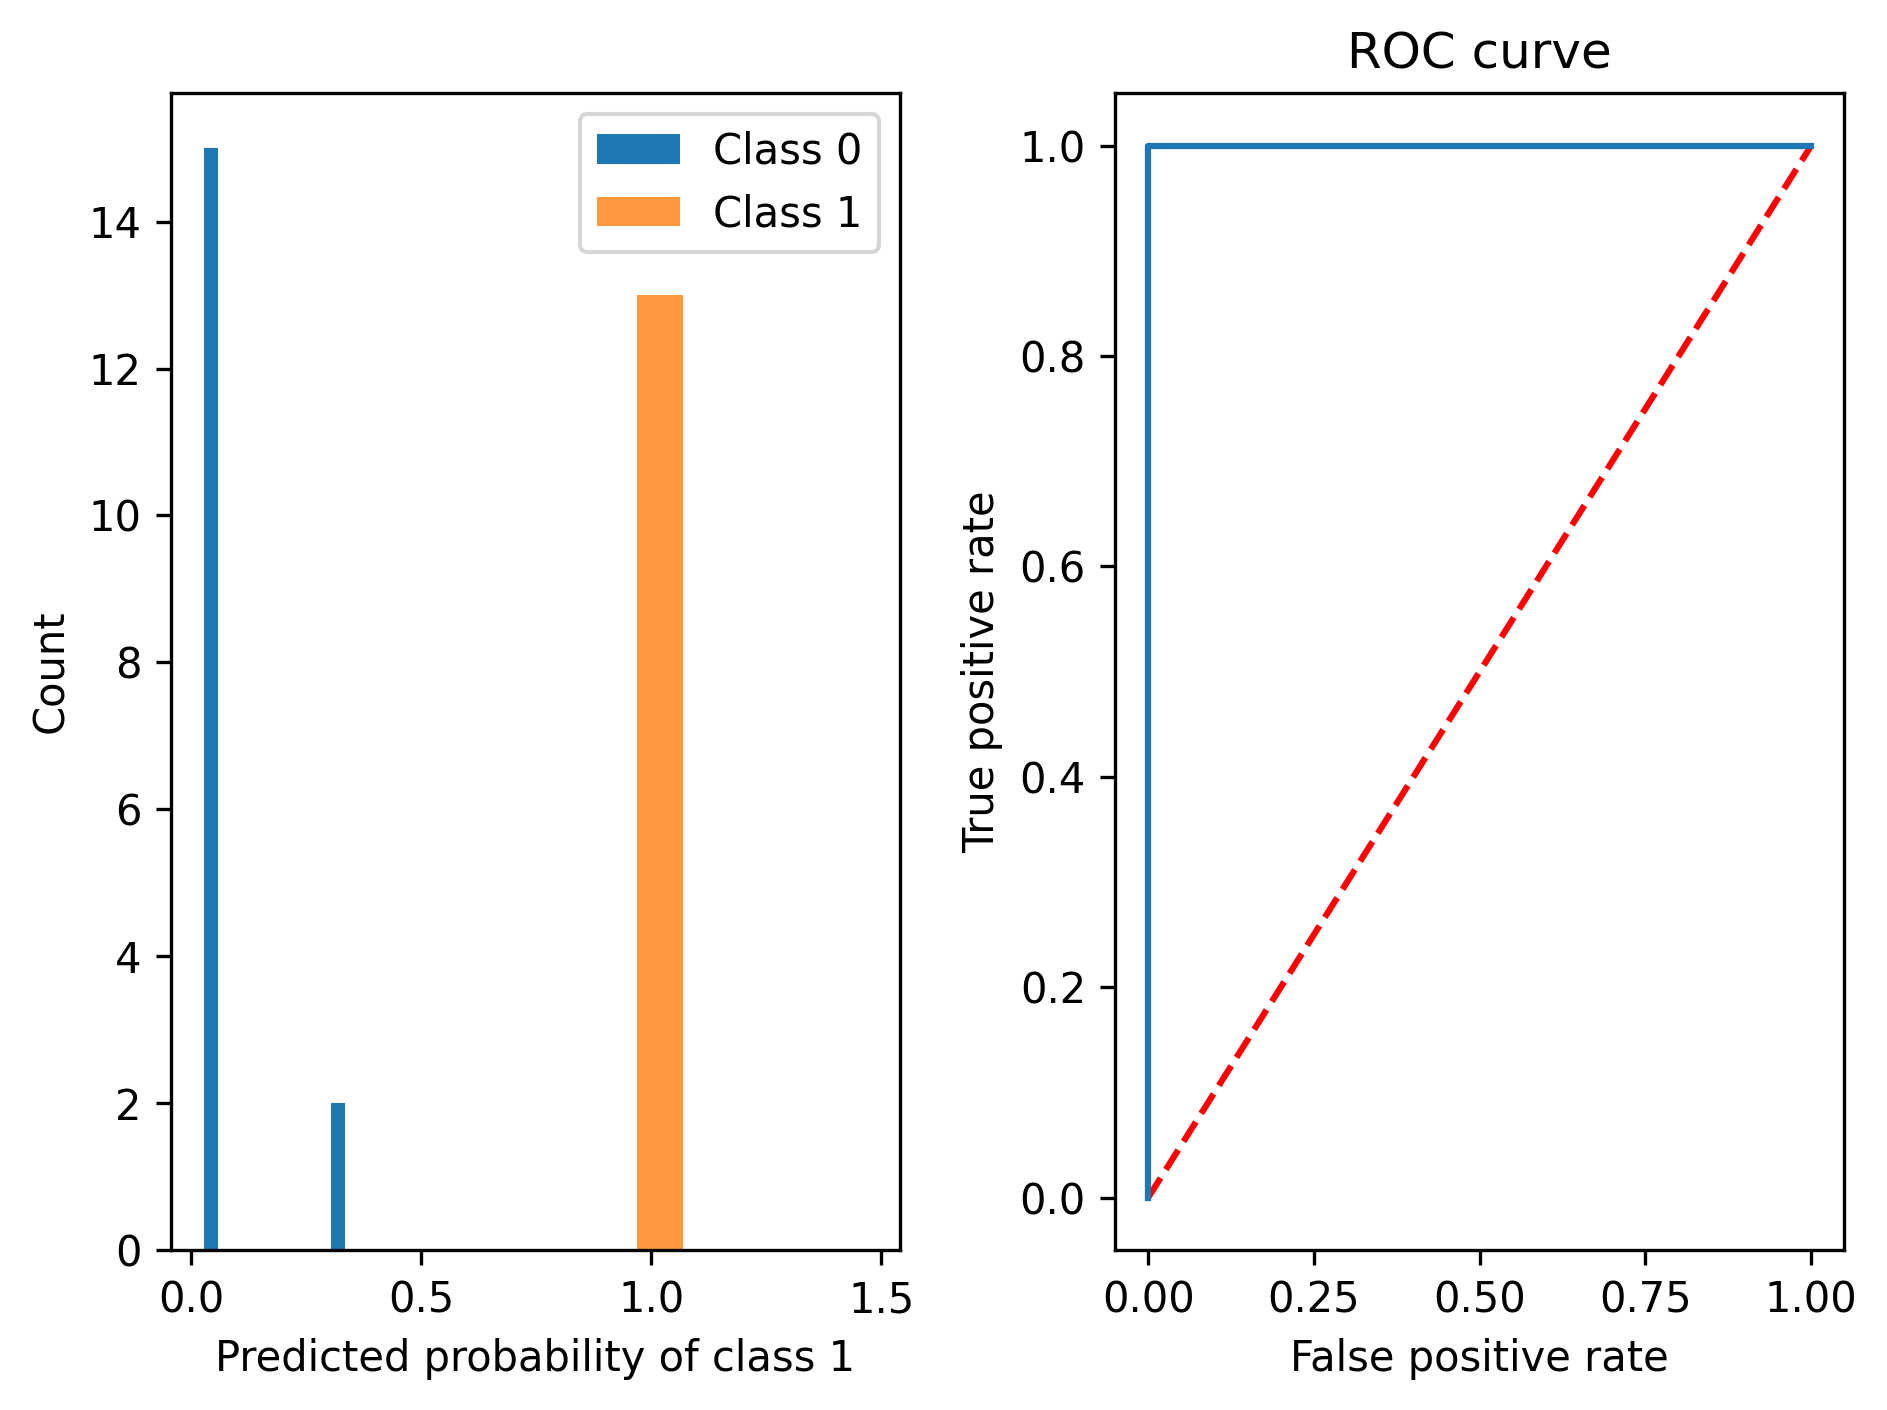

In [27]:
probs = bayesian_rule.predict_proba(X_test_brl_df)
viz_classification_preds(probs, test_y_modified)

## RuleFit

The algorithm has two main steps:

- Rule generation: The algorithm generates a set of interpretable if-then rules from the data using a decision tree-based method such as CART.
- Rule fitting: The algorithm fits a linear model to the predictions of the generated rules.

In the first step, the algorithm generates a set of if-then rules using decision tree-based methods like CART. These rules are used to partition the feature space into regions, and each region is associated with a predicted class.

In the second step, the algorithm fits a linear model to the predictions of the generated rules. The linear model is used to adjust the predictions of the rules to account for any errors or biases in the rules. The linear model is also used to assign weights to the rules, which can be used to interpret the relative importance of the rules.

The algorithm is computationally efficient, easy to interpret and it can handle large datasets. However, it is limited to binary classification problems, and it might not be as accurate as some other methods like Random Forest or Gradient Boosting.

<img src="https://github.com/ficstamas/FateML/raw/master/notebooks/images/rulefit.jpg" width=500>

In [28]:
from imodels import RuleFitRegressor

rulefit = RuleFitRegressor(max_rules=10, random_state=0)
rulefit.fit(iris.train_x, iris.train_y, feature_names=iris.train_x.columns)

E:\Programs\Anaconda3\envs\FateML\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


RuleFitRegressor(max_rules=10, random_state=0)

#### Feature importance

In [29]:
from sklearn import metrics

preds = rulefit.predict(iris.test_x)
print(f'test r2: {metrics.r2_score(iris.test_y, preds):0.3f}')

rules = rulefit._get_rules()
rules = rules[rules.coef != 0].sort_values("importance", ascending=False)

# 'rule'
# 'coef' weight of the decision
# 'support' coverage
# 'importance' importance of the rule
rules.style.background_gradient(cmap='viridis')

test r2: 0.783


,rule,type,coef,support,importance
4,petal width (cm) <= 0.75,rule,-0.549813,0.323810,0.257273
5,petal length (cm) <= 4.85,rule,-0.311917,0.609524,0.152171
9,petal width (cm) <= 1.55,rule,-0.145908,0.619048,0.070856
8,petal width (cm) <= 1.45,rule,-0.112854,0.561905,0.055993
7,petal length (cm) <= 2.7,rule,-0.041842,0.323810,0.019579
6,petal length (cm) <= 4.95,rule,-0.033513,0.647619,0.016010
12,petal length (cm) > 4.8 and petal width (cm) > 0.7,rule,0.002171,0.390476,0.001059
11,petal width (cm) > 0.75,rule,0.000716,0.676190,0.000335
10,petal length (cm) <= 4.4,rule,-0.000002,0.523810,0.000001


# Other Popular Models

## Näive Bayes Classifier

Naive Bayes Classifier is a simple probabilistic machine learning algorithm that is based on Bayes' Theorem. The "näive" in the name refers to the assumption that the features are independent of each other, which is not always the case in real-world datasets. There are several variations of Naive Bayes Classifier, but the most common ones are: Gaussian, Multinomial and Bernoulli Näive Bayes Classifiers. Main difference is the assumption about the distribution of the features. Gaussian is suitable to hand continuous data, on the other hand Multinomial is better for categorical data.

For a classification problem with $K$ classes and $N$ features, the Naive Bayes Classifier is formulated as follows:

1. Estimate the prior probability of each class: $P(C_k), k=1,2, \dots, K$. This can be done by counting the number of examples of each class in the training dataset and dividing by the total number of examples.
2. Estimate the likelihood of each feature given each class: $P(x_n\mid C_k), n=1,2, \dots, N \text{ and } k=1,2, \dots, K$. This can be done using the training data and assuming a specific probability distribution for each feature, such as a Gauss (normal) distribution for continuous variables or a multinomial distribution for discrete variables.
3. Use Bayes' Theorem to classify new examples: Given a new example with feature values $x_1, x_2, ..., x_N$, the algorithm computes the posterior probability of each class given the example: $P(C_k\mid x = \{x_1, x_2, \dots, x_N\}), k=1,2, ..., K$. The class with the highest probability is chosen as the prediction for the example.

$$P(C_k\mid x)=P(C_k)\prod_{i=1}^nP(x_i\mid C_k).$$

In [30]:
from sklearn.naive_bayes import GaussianNB

naive = GaussianNB()
naive.fit(iris.train_x, iris.train_y['target'])
naive.score(iris.test_x, iris.test_y['target'])

1.0

### Permutation feature importance

It is also known as "Mean Decrease Impurity" for tree-based models, and "Mean Decrease Accuracy" for other models.

Permutation feature importance is a method for calculating the importance of features in a machine learning model. It is a simple, model-agnostic method that can be used to understand how each feature contributes to the predictions of a model. The idea behind permutation feature importance is to measure the change in the model's performance when a feature is randomly permuted, and the resulting change in performance is used as an estimate of the feature's importance.

In [31]:
from sklearn.inspection import permutation_importance

imps = permutation_importance(naive, iris.test_x, iris.test_y['target'], random_state=0)
importances = imps.importances_mean
std = imps.importances_std
indices = np.argsort(importances)[::-1]
features = iris.test_x.columns

# Print the feature ranking
print("Feature ranking:")
for f in range(iris.test_x.shape[1]):
    print("%d. %s (%f ± %f)" % (f + 1, features[indices[f]], importances[indices[f]], std[indices[f]]))

Feature ranking:
1. petal width (cm) (0.393333 ± 0.064636)
2. petal length (cm) (0.380000 ± 0.068638)
3. sepal length (cm) (0.026667 ± 0.013333)
4. sepal width (cm) (0.013333 ± 0.026667)


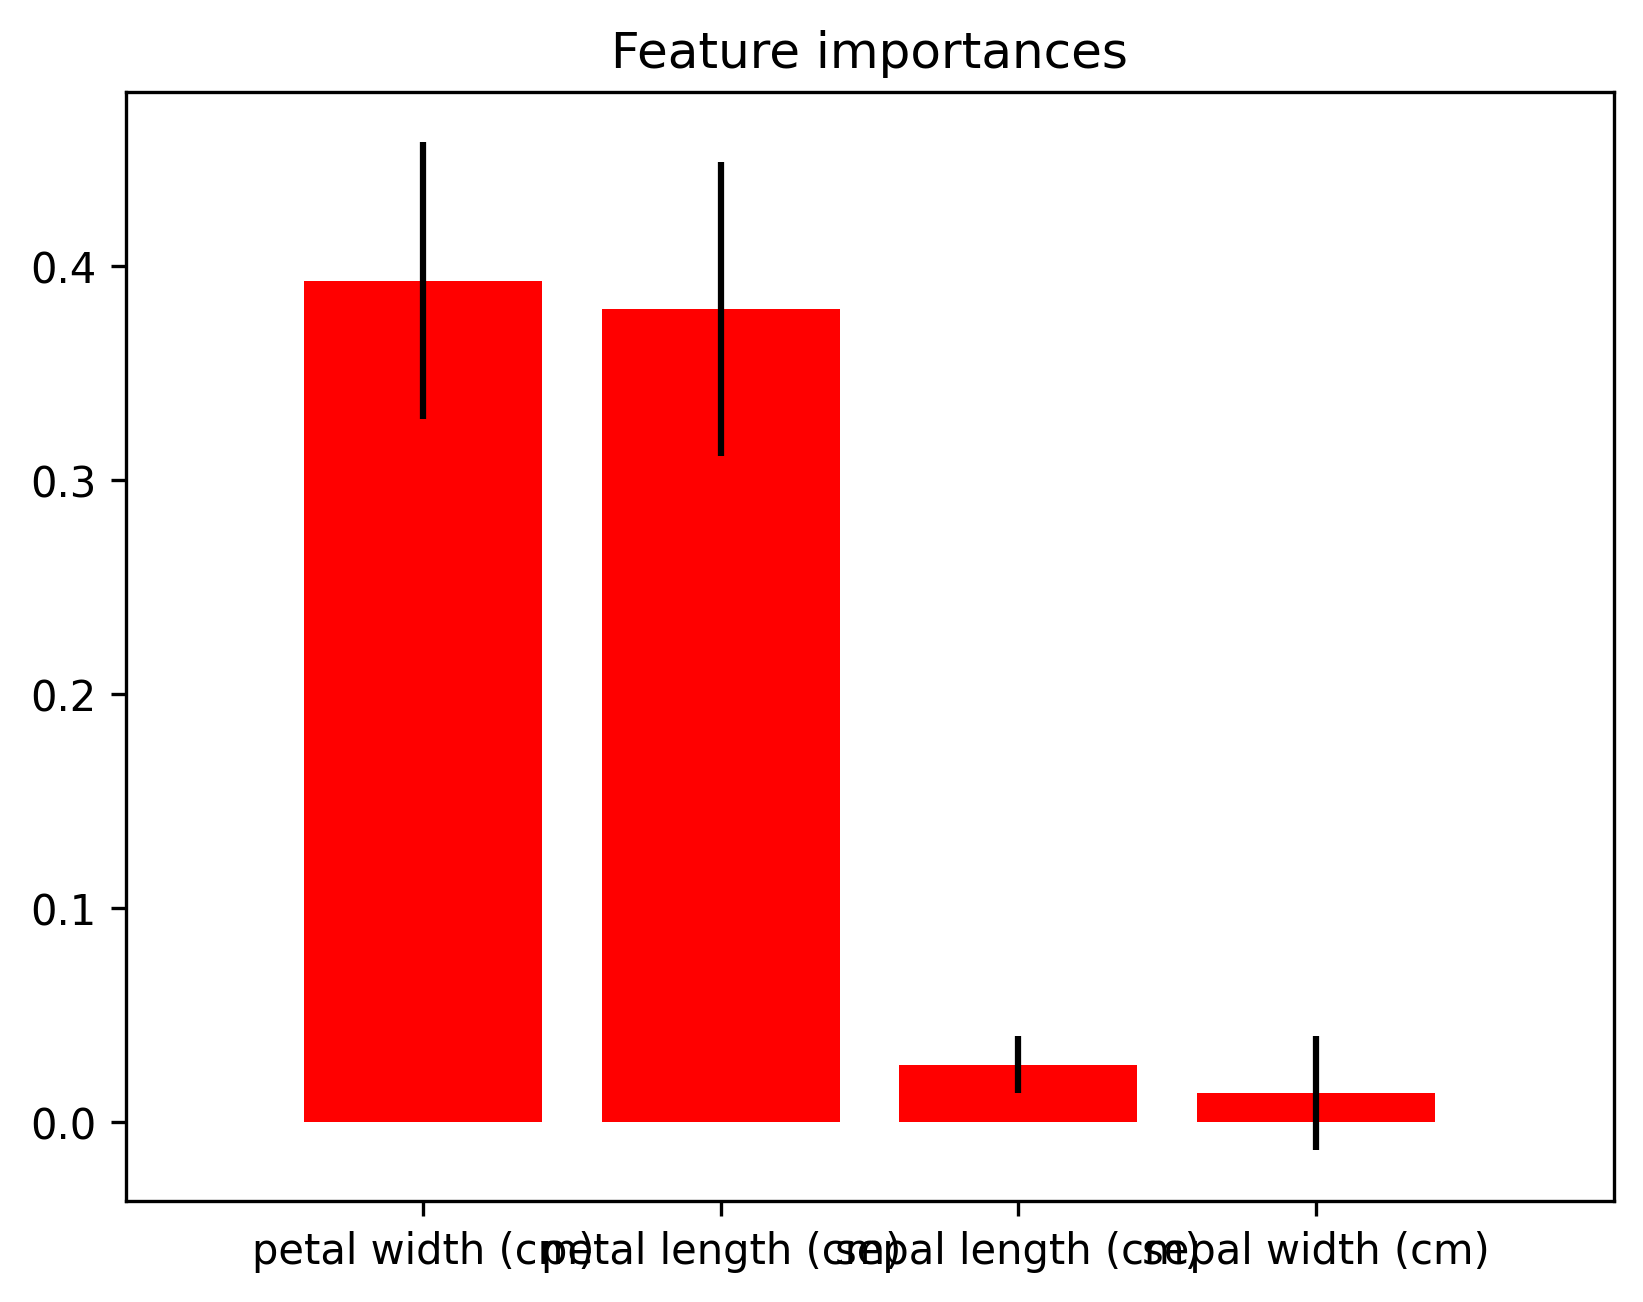

In [53]:
plt.title("Feature importances")
plt.bar(range(iris.test_x.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(iris.test_x.shape[1]), [features[indices[i]] for i in range(4)])
plt.xlim([-1, iris.test_x.shape[1]])
plt.show()

### Visualization (as pair of features)

In [33]:
selected_features = ['petal width (cm)', 'petal length (cm)']

naive = GaussianNB()
naive.fit(iris.train_x[selected_features], iris.train_y['target'])
naive.score(iris.test_x[selected_features], iris.test_y['target'])

1.0

[(-0.9, 3.5), (0.0, 7.3)]

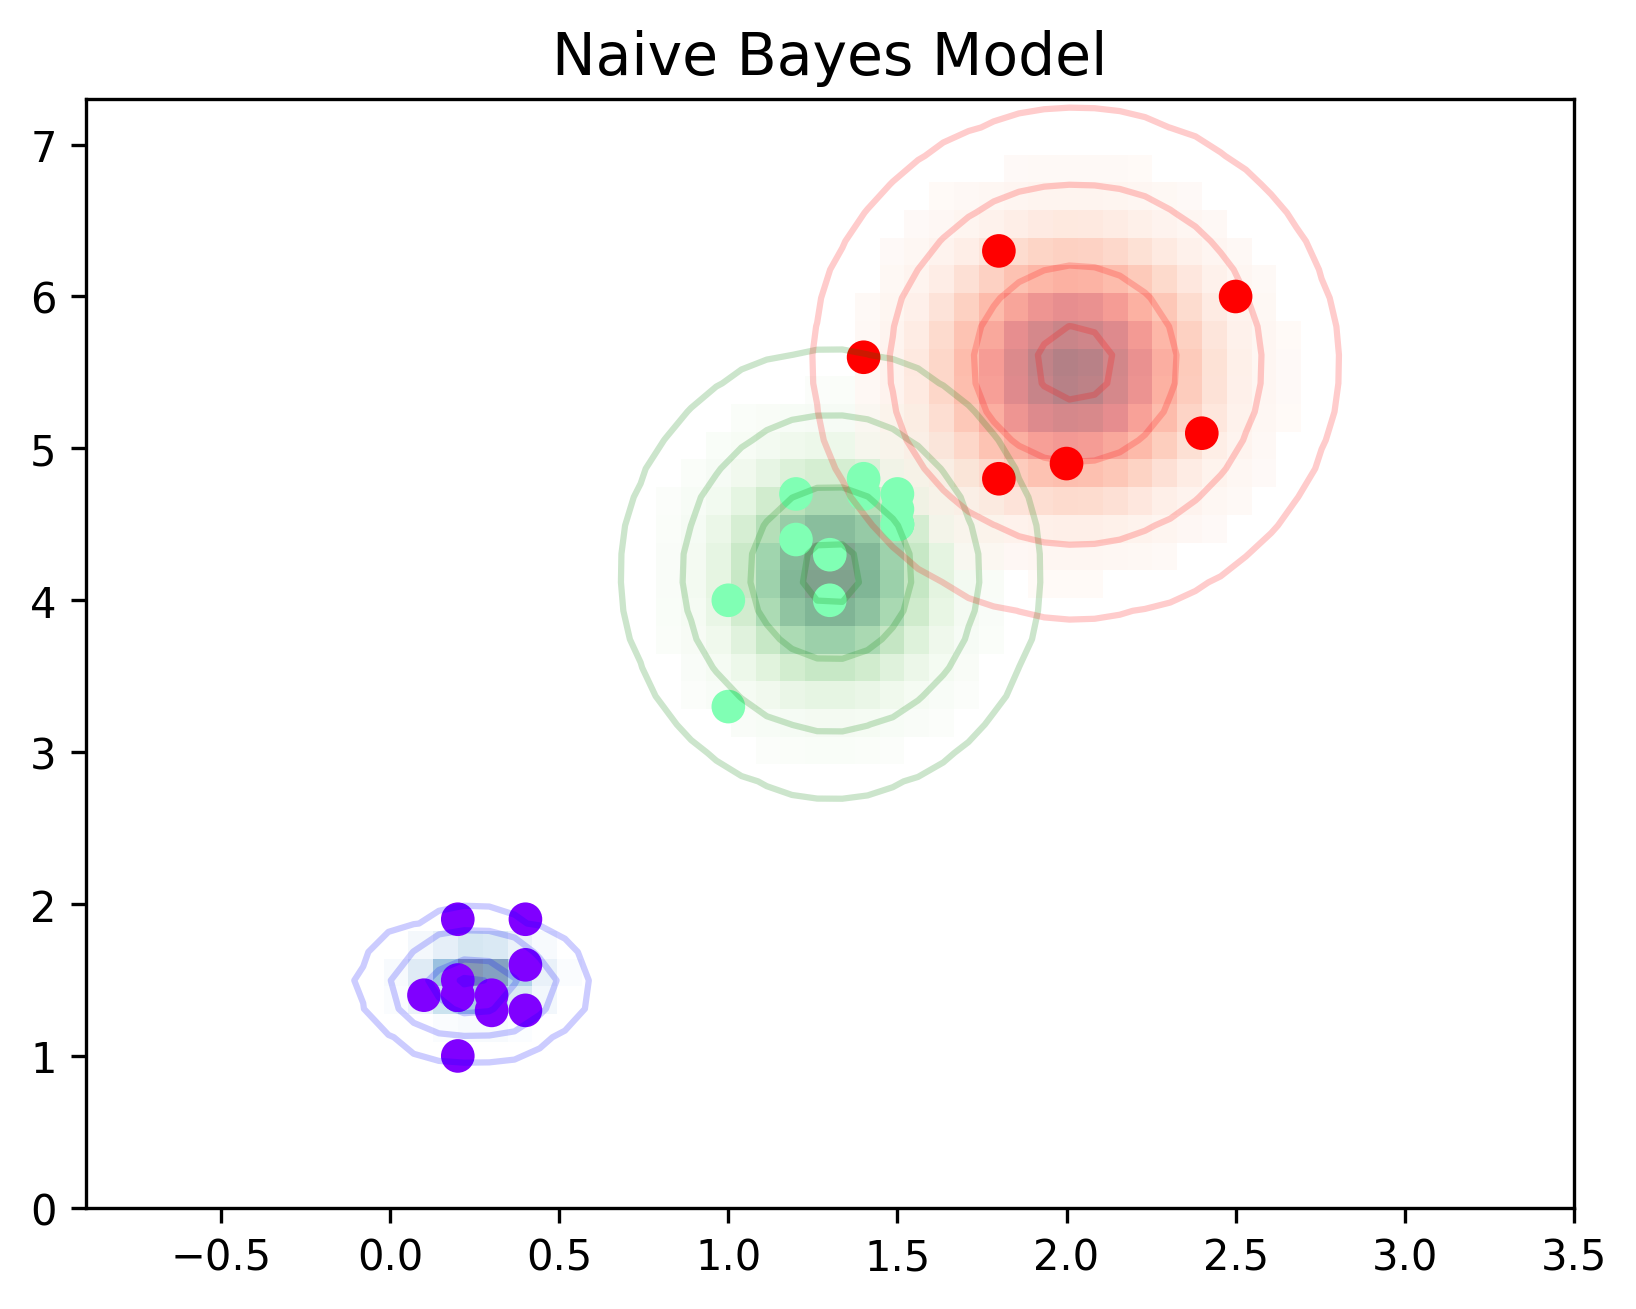

In [34]:
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('rainbow', 3)

fig, ax = plt.subplots()

_X = iris.test_x[selected_features]

ax.scatter(_X[_X.columns[0]], _X[_X.columns[1]], c=iris.test_y['target'], s=50, cmap=viridis)
ax.set_title('Naive Bayes Model', size=14)

_X = iris.test_x[selected_features]

xlim = (np.min(_X[_X.columns[0]])-1, np.max(_X[_X.columns[0]])+1)
ylim = (np.min(_X[_X.columns[1]])-1, np.max(_X[_X.columns[1]])+1)

xg = np.linspace(xlim[0], xlim[1], 60)
yg = np.linspace(ylim[0], ylim[1], 40)
xx, yy = np.meshgrid(xg, yg)
Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T

mu_= naive.theta_  # mean
std_ = np.sqrt(naive.var_)  # standard deviation

for label, color in enumerate(['blue', 'green', 'red']):
    mask = (iris.test_y == label)
    mu, std = mu_[label], std_[label]
    cent = -0.5 * (Xgrid - mu) ** 2
    var = cent / std.reshape(1, -1) ** 2
    P = np.exp(var).prod(1)
    Pm = np.ma.masked_array(P, P < 0.03)
    ax.pcolorfast(xg, yg, Pm.reshape(xx.shape), alpha=0.5,
                  cmap=color.title() + 's')
    ax.contour(xx, yy, P.reshape(xx.shape),
               levels=[0.01, 0.1, 0.5, 0.9],
               colors=color, alpha=0.2)
    
ax.set(xlim=xlim, ylim=ylim)

## k-NN Classifier

The k-Nearest Neighbors (k-NN) classifier is a simple and popular machine learning algorithm that is used for classification problems. The basic idea behind the k-NN classifier is to predict the class of a new example by finding the k examples in the training dataset that are closest (or "nearest") to the new example, and then determining the most common class among those k examples. We can utilize several different metrics to measure the distance between samples but usually Euclidean distance is used. However, a suitable metric depends on the data..

### Regression

In [35]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=7)

knn.fit(diabetes.train_x, diabetes.train_y)
knn.score(diabetes.test_x, diabetes.test_y)

0.22640570275839067

#### Explained by its neightbours

In [36]:
sample = pd.concat([diabetes.test_x[:1], diabetes.test_y[:1]], axis=1)
sample

,age,bmi,bp,s1,s2,s3,s4,s5,s6,sex,target
362,0.019913,0.104809,0.070072,-0.035968,-0.026679,-0.024993,-0.002592,0.003709,0.040343,0.05068,321.0


In [37]:
distance, ind = knn.kneighbors(sample[diabetes.train_x.columns])
distance, ind

(array([[0.04551833, 0.06648226, 0.0779317 , 0.08690909, 0.0927916 ,
         0.09770554, 0.10002168]]),
 array([[276,  28, 106,  48, 282,  44, 167]], dtype=int64))

In [38]:
pd.concat([diabetes.train_x.iloc[ind[0]], diabetes.train_y.iloc[ind[0]]], axis=1)

,age,bmi,bp,s1,s2,s3,s4,s5,s6,sex,target
138,0.034443,0.111276,0.076958,-0.031840,-0.033881,-0.021311,-0.002592,0.028020,0.073480,0.05068,336.0
163,0.016281,0.072474,0.076958,-0.008449,0.005575,-0.006584,-0.002592,-0.023647,0.061054,0.05068,131.0
240,0.048974,0.074630,0.066629,-0.009825,-0.002253,-0.043401,0.034309,0.033654,0.019633,0.05068,275.0
341,0.030811,0.059541,0.056301,-0.022208,0.001191,-0.032356,-0.002592,-0.024795,-0.017646,0.05068,263.0
0,0.038076,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,0.05068,151.0
116,0.048974,0.058463,0.070072,0.013567,0.020607,-0.021311,0.034309,0.022004,0.027917,0.05068,275.0
270,0.005383,0.030440,0.083844,-0.037344,-0.047347,0.015505,-0.039493,0.008641,0.015491,0.05068,202.0


In [39]:
diabetes.train_y.iloc[ind[0]].mean()

target    233.285714
dtype: float64

In [40]:
knn.predict(sample[diabetes.train_x.columns])

array([[233.28571429]])

<AxesSubplot:>

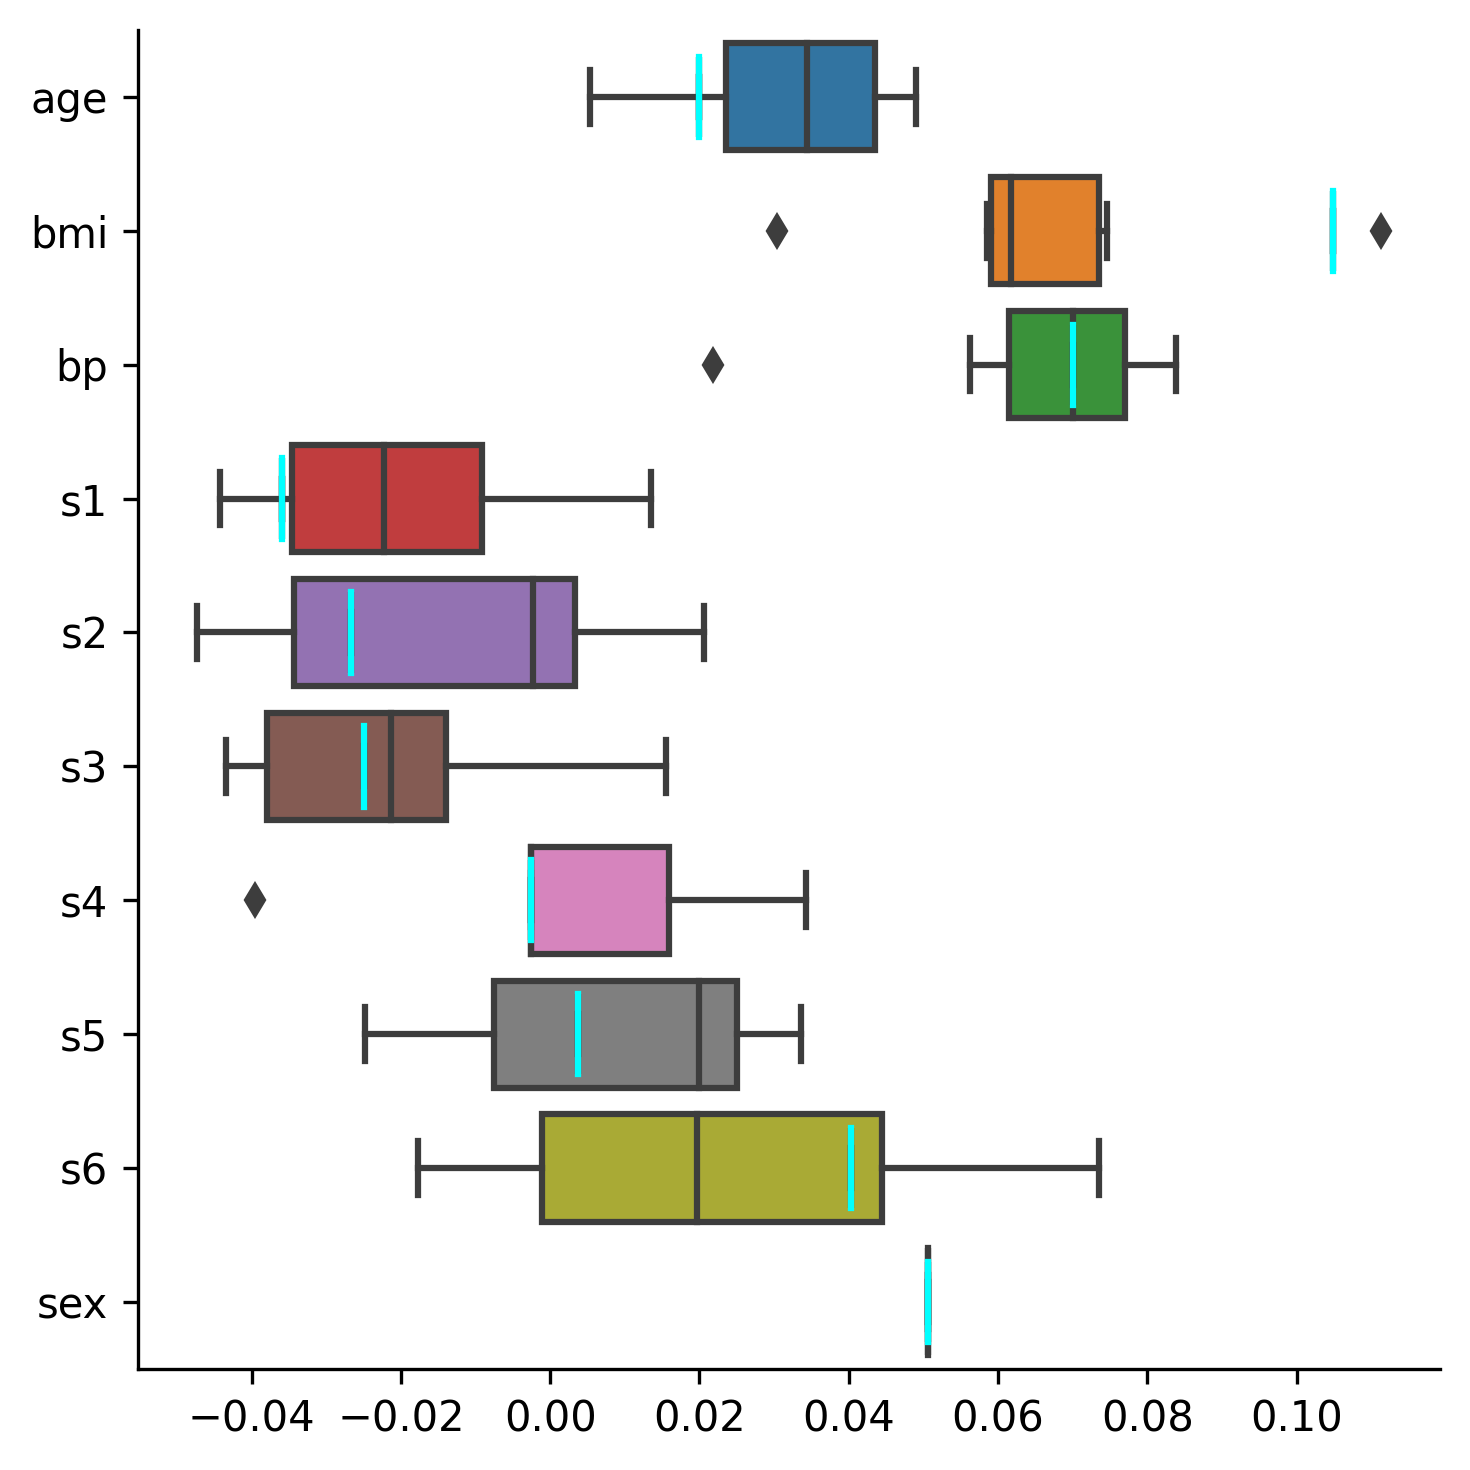

In [41]:
sns.catplot(kind="box", data=diabetes.train_x.iloc[ind[0]], orient="h")
sns.boxplot(data=diabetes.test_x[:1], width=.6, orient="h", medianprops={"color": "cyan"})

### Classification

In [42]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=10)

knn.fit(iris.train_x, iris.train_y['target'])
knn.score(iris.test_x, iris.test_y['target'])

1.0

#### Explained by its neightbours

In [43]:
sample = pd.concat([iris.test_x[:1], iris.test_y[:1]], axis=1)
sample

,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),target
114,5.1,2.4,5.8,2.8,2


In [44]:
distance, ind = knn.kneighbors(sample[iris.train_x.columns])
distance, ind

(array([[0.50990195, 0.50990195, 0.51961524, 0.64031242, 0.72801099,
         0.75498344, 0.77459667, 0.78740079, 0.78740079, 0.80622577]]),
 array([[ 63,  17, 101,  84,  19,  23,  29,   3,  33,  42]], dtype=int64))

In [45]:
pd.concat([iris.train_x.iloc[ind[0]], iris.train_y.iloc[ind[0]]], axis=1)

,petal length (cm),petal width (cm),sepal length (cm),sepal width (cm),target
101,5.1,1.9,5.8,2.7,2
142,5.1,1.9,5.8,2.7,2
113,5.0,2.0,5.7,2.5,2
149,5.1,1.8,5.9,3.0,2
127,4.9,1.8,6.1,3.0,2
115,5.3,2.3,6.4,3.2,2
146,5.0,1.9,6.3,2.5,2
70,4.8,1.8,5.9,3.2,1
148,5.4,2.3,6.2,3.4,2
132,5.6,2.2,6.4,2.8,2


In [46]:
iris.train_y.iloc[ind[0]].value_counts()

target
2         9
1         1
dtype: int64

In [47]:
knn.predict(sample[iris.train_x.columns])

array([2])

<AxesSubplot:>

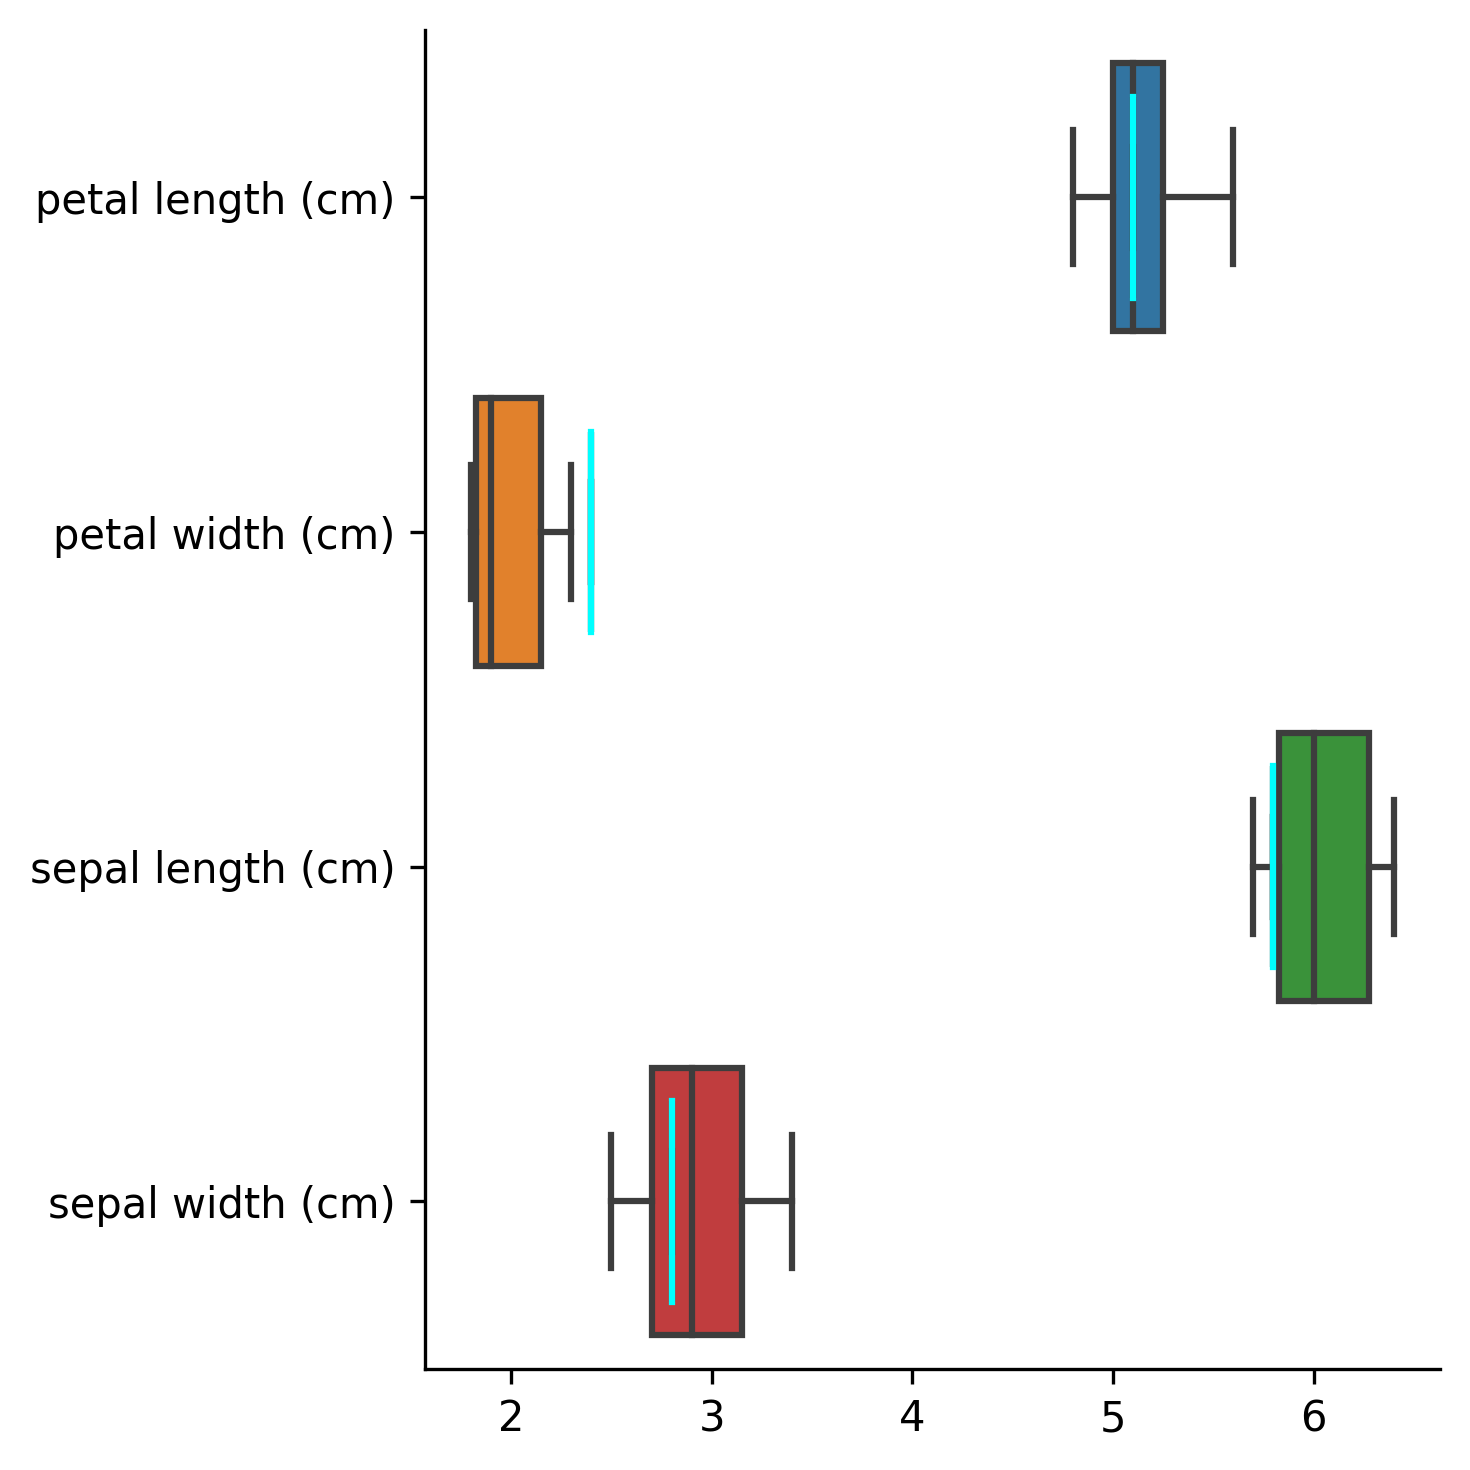

In [48]:
sns.catplot(kind="box", data=iris.train_x.iloc[ind[0]], orient="h")
sns.boxplot(data=iris.test_x[:1], width=.6, orient="h", medianprops={"color": "cyan"})